In [3]:
import pandas as pd
from dataset_manager import DatasetManager

# 1 - Load de dados

In [7]:
import os

DATA_PATH = "./data"

def download_file(url, final_path=None):
    import urllib.request

    if not final_path:
        name = url.split("/")[-1]
        final_path = "{}/{}".format(DATA_PATH, name)
    urllib.request.urlretrieve(url, final_path)
    return final_path

def unzip_file(path_to_zip_file, final_path=None):
    import zipfile
    
    if not final_path:
        name = os.path.basename(path_to_zip_file).split(".")[0]
        final_path = "{}/{}".format(DATA_PATH, name)

    zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
    zip_ref.extractall(final_path)
    zip_ref.close()
    return final_path

def download_all(manager, force=False):
    for dataset in manager.list_datasets().to_dict('records'):
        if not os.path.exists(dataset["local_source"]) or force:
            if "zipped" in dataset["format"]:
                path_downloaded = download_file(dataset["source"])
                unzip_file(path_downloaded, dataset["local_source"])
            else:
                download_file(dataset["source"], dataset["local_source"])

def get_dataset_source(manager, identifier):
    dataset = manager.get_dataset(identifier)
    if os.path.isdir(dataset["local_source"]):
        return [os.path.join(dataset["local_source"], filename) for filename in os.listdir(dataset["local_source"])]
    elif os.path.isfile(dataset["local_source"]):
        return dataset["local_source"]
    else:
        raise Exception("No dataset exists as {}".format(dataset["local_source"]))
        

In [8]:
dataset_path = "./datasets"
manager = DatasetManager(dataset_path)
manager.list_datasets()

,description,format,identifier,local_source,source
0,Média de alunos por turmas em escolas e creche...,xls zipped,media_alunos_2008,./data/media_alunos_2008,http://download.inep.gov.br/informacoes_estati...
1,Quantidade de creches e pré-escolas cujas obra...,json,construcao_creche,./data/construcao_creche.json,http://api.pgi.gov.br/api/1/serie/2620.json
2,Quantidade de projetos para a construção de cr...,json,aprovacao_construcao_creche,./data/aprovacao_construcao_creche.json,http://api.pgi.gov.br/api/1/serie/2555.json
3,Valor do investimento para a construção das cr...,json,investimento_em_construcao_creche,./data/investimento_em_construcao_creche.json,http://api.pgi.gov.br/api/1/serie/1703.json
4,Média de alunos por turmas em escolas e creche...,xls zipped,media_alunos_2010,./data/media_alunos_2010,http://download.inep.gov.br/informacoes_estati...
5,Média de alunos por turmas em escolas e creche...,xls zipped,media_alunos_2009,./data/media_alunos_2009,http://download.inep.gov.br/informacoes_estati...


In [9]:
download_all(manager, False)

In [82]:
def read_media_aluno_by_year(year):
    df_name = "media_alunos_{}".format(year)
    df = manager.get_dataset(df_name)
    df_local = get_dataset_source(manager, df_name)
    df = pd.read_excel(df_local[0], sheet_name=[0,1])
    df = pd.concat(df)
    return df

In [83]:
alunos_2008 = read_media_aluno_by_year("2008")
alunos_2009 = read_media_aluno_by_year("2009")
alunos_2010 = read_media_aluno_by_year("2010")

In [84]:
alunos = pd.concat([alunos_2008,alunos_2009, alunos_2010])

# 2 - Rename de colunas

In [85]:
def renamed(df):
    df_renamed = df.rename(
        columns={
            "Unnamed: 0" : "ano",
            "Ministério da Educação":"regiao",
            "Unnamed: 2":"estado",
            "Unnamed: 3" : "cod_municipio",
            "Unnamed: 4" : "municipio",
            "Unnamed: 5" : "localizacao",
            "Unnamed: 6" : "rede",
            "Unnamed: 7" : "media_alunos_etapa",
            "Unnamed: 8" : "rede",
            "Unnamed: 7" : "educacao_infantil - total",
            "Unnamed: 8" : "educacao_infantil - creche",
            "Unnamed: 9" : "educacao_infantil - pre-escola",
            "Unnamed: 10" : "ensino_fundamental - total",
            "Unnamed: 11" : "ensino_fundamental - anos_inic",
            "Unnamed: 12" : "ensino_fundamental - anos_finais",
            "Unnamed: 13" : "ensino_fundamental - 1ano",
            "Unnamed: 14" : "ensino_fundamental - 2ano",
            "Unnamed: 15" : "ensino_fundamental - 3ano",
            "Unnamed: 16" : "ensino_fundamental - 4ano",
            "Unnamed: 17" : "ensino_fundamental - 5ano",
            "Unnamed: 18" : "ensino_fundamental - 6ano",
            "Unnamed: 19" : "ensino_fundamental - 7ano",
            "Unnamed: 20" : "ensino_fundamental - 8ano",
            "Unnamed: 21" : "ensino_fundamental - 9ano",
            "Unnamed: 22" : "turmas_unificadas",
            "Unnamed: 23" : "ensino_medio - total_media",
            "Unnamed: 24" : "ensino_medio - 1ano",
            "Unnamed: 25" : "ensino_medio - 2ano",
            "Unnamed: 26" : "ensino_medio - 3ano",
            "Unnamed: 27" : "ensino_medio - 4ano",
            "Unnamed: 28" : "medio_nao_seriado"
        }
    )
    return df_renamed

In [98]:
alunos_renamed = renamed(alunos)

# 3 - Filtro

In [99]:
def filter_df(df):
    df_renamed_filtred = df[
        (~df["municipio"].isnull()) & 
        (df["ano"] != "Ano")]
    
    df_clean = df_renamed_filtred[["ano",
                        "estado",
                        "municipio",
                        "localizacao",
                        "rede",
                        "educacao_infantil - creche",
                        "educacao_infantil - pre-escola"]]
    
    return df_clean

In [100]:
alunos_filtered = filter_df(alunos_renamed)

## Filtro alunos apenas no `Rio de Janeiro`

In [101]:
city_name = "RIO DE JANEIRO"
state_name = "RJ"

In [105]:
alunos_rj = alunos_filtered[ (alunos_filtered["municipio"] == city_name) &
                              (alunos_filtered["estado"] == state_name)]

In [106]:
alunos_rj[alunos_rj["localizacao"] == "Total"]

ano estado       municipio localizacao       rede  \
1 12037  2008     RJ  RIO DE JANEIRO       Total      Total   
  12038  2008     RJ  RIO DE JANEIRO       Total    Federal   
  12039  2008     RJ  RIO DE JANEIRO       Total   Estadual   
  12040  2008     RJ  RIO DE JANEIRO       Total  Municipal   
  12041  2008     RJ  RIO DE JANEIRO       Total    Privada   
  12042  2008     RJ  RIO DE JANEIRO       Total    Publico   
  11980  2009     RJ  RIO DE JANEIRO       Total      Total   
  11981  2009     RJ  RIO DE JANEIRO       Total    Federal   
  11982  2009     RJ  RIO DE JANEIRO       Total   Estadual   
  11983  2009     RJ  RIO DE JANEIRO       Total  Municipal   
  11984  2009     RJ  RIO DE JANEIRO       Total    Privada   
  11985  2009     RJ  RIO DE JANEIRO       Total    Publico   
  11935  2010     RJ  RIO DE JANEIRO       Total      Total   
  11936  2010     RJ  RIO DE JANEIRO       Total    Federal   
  11937  2010     RJ  RIO DE JANEIRO       Total   Estadual   
  11938  2010     RJ  RIO DE JANEIRO       Total  Municipal   
  11939  2010     RJ  RIO DE JANEIRO       Total    Privada   
  11940  2010     RJ  RIO DE JANEIRO       Total    Publico   

        educacao_infantil - creche educacao_infantil - pre-escola  
1 12037                       16.4                             18  
  12038                       17.3                           20.6  
  12039                       14.7                           15.3  
  12040                       22.8                           23.8  
  12041                       13.6                           12.7  
  12042                       22.6                           23.7  
  11980                       16.2                           17.8  
  11981                       14.8                           14.8  
  11982                       14.5                           14.1  
  11983                       22.7                           23.5  
  11984                       13.2                           12.9  
  11985                       22.5                           23.4  
  11935                       16.3                           16.9  
  11936                       14.1                           15.2  
  11937                         18                           15.3  
  11938                       22.7                           22.9  
  11939                       13.3                           12.8  
  11940                       22.5                           22.8

In [149]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")

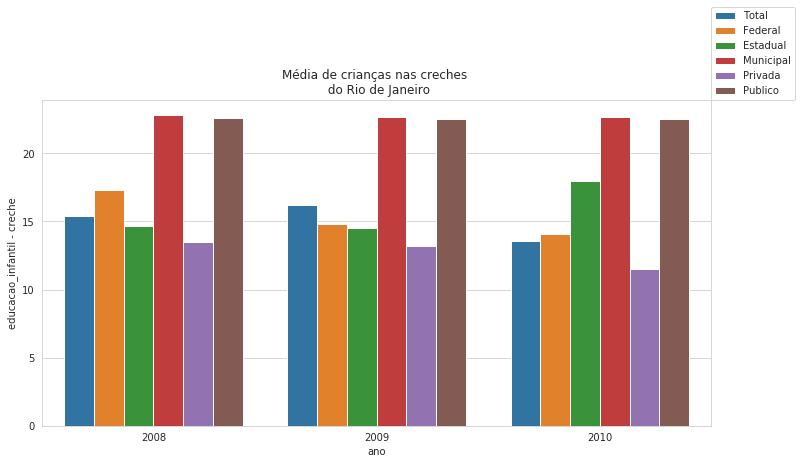

In [150]:
plt.subplots(figsize=(12,6))
plt.title("Média de crianças nas creches \n do Rio de Janeiro")

sns.barplot(x="ano",
            y="educacao_infantil - creche",
            hue="rede",
            data=alunos_rj,
            ci=None)
plt.legend(loc=[1,1])
